Stacking Averaged models rmse score:0.0866
Stacking Averaged models rmse score:0.1242


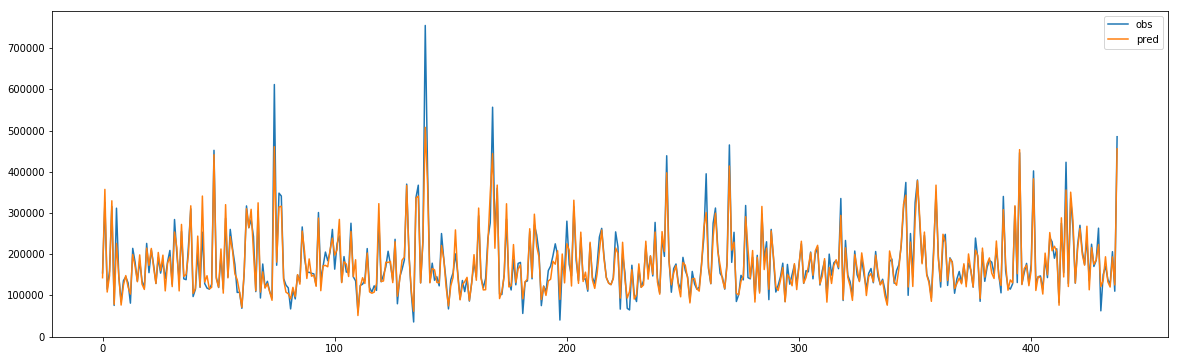

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import RobustScaler, Imputer, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,KFold
from sklearn.linear_model import LassoCV, LinearRegression,LogisticRegression,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR
from scipy.stats import randint as sp_randint, skew,norm
import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from pipeline_pkg.utils import read_train_path, read_test_path, SelectItems,ImputeNa,MultiLabelEncoder,FillbyGroup,FillbyType,Add6vars,Modiftype,StackingAveragedModels,rmse

import warnings
warnings.filterwarnings("ignore")

rf = RandomForestRegressor(max_depth=3,n_estimators=500)

svr = LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=0, tol=1e-05, verbose=0)

xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_knn = KNeighborsRegressor(n_neighbors=3, weights='uniform', leaf_size = 10, p=2,  n_jobs=4)

#This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


con_impute = Pipeline([ ('con_sel',SelectItems('float')),
                        ('impute_median', Imputer( strategy = 'median')),
                        ('scaler',StandardScaler()),
                      ])
int_impute = Pipeline([('con_sel',SelectItems('int64')),
                       ('impute_median',Imputer(strategy = 'median')),
                       ('scaler',StandardScaler()),    
                      ])
cat_impute = Pipeline([ ('cat_sel',SelectItems('object')),
                        ('impute_unknown',ImputeNa(word_fill='None')),
                        ('label', MultiLabelEncoder()),
                        ('onehot',OneHotEncoder(sparse=False,handle_unknown='ignore')),                    
                      ])


impute_part  = FeatureUnion([('con_part',con_impute),
                             ('int_part',int_impute),
                             ('cat_part',cat_impute)])


df_train = read_train_path()

X, y = df_train.drop(['Id','SalePrice'],axis = 1), np.log(df_train[['SalePrice']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle=True)

prep = Pipeline([('lotFrbyngb',FillbyGroup(var_gp = 'Neighborhood', var_to_fill = 'LotFrontage')),
                 
                 ('fillbytypes',FillbyType(vars_na = ['Alley', 'MasVnrType','BsmtQual','BsmtCond','BsmtExposure',\
                                                    'BsmtFinType1','BsmtFinType2','FireplaceQu',\
                                                    'PoolQC','MiscFeature','Fence','GarageCars',\
                                                    'GarageType','GarageFinish','GarageQual','GarageCond'],
                                           vars_0 = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',\
                                                    'BsmtFullBath','BsmtHalfBath','GarageArea','GarageYrBlt'], 
                                           vars_freq = ['Electrical','MSZoning','Utilities','Exterior1st',\
                                                        'Exterior2nd','KitchenQual','SaleType','Functional'])),
                 
                 ('add_6vars',Add6vars()),
                 
                 ('modif_2types', Modiftype()),
                 
                 ('impute_part', impute_part)                
                 
])

stackingmodels = StackingAveragedModels(base_models = (ENet, xgb, KRR, svr),
                                                 meta_model = lasso)



X_train_new = prep.fit_transform(X_train)

stackingmodels.fit(pd.DataFrame(X_train_new), y_train)

y_train_predict = stackingmodels.predict(pd.DataFrame(X_train_new))

rmse_train = rmse(pd.DataFrame(y_train_predict),y_train)
print("Stacking Averaged models rmse score:{:.4f}".format(rmse_train))

X_test_new = prep.transform(X_test)
y_test_predict = stackingmodels.predict(pd.DataFrame(X_test_new))

rmse_test = rmse(pd.DataFrame(y_test_predict),y_test)
print("Stacking Averaged models rmse score:{:.4f}".format(rmse_test))

pd.DataFrame({'obs':np.exp(y_test.values.reshape(-1)), 
              'pred':np.exp(y_test_predict)}).plot(figsize=(20,6))